# Data Analysis
Analyze the dataset (`storage/corpus` and `qa_resources/questions.csv`) provided to you and the text associated embeddings, and report TWO significant findings you believe will impact the model or system's performance.

Two factors that will impact the system's performance are (1) chunks per document and (2) embedding distributions of corpus documents.

#### Import necessary libraries

In [1]:
import sys
sys.path.insert(1,'../')
from src.retrieval.search import Measure
from pipeline import Pipeline
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import re
import os
import matplotlib.cm as cm

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt_tab to /Users/riley/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Precompute all embeddings for all corpus documents
To perform the analyses, we'll need to calculate the embeddings for all for all of the corpus documents. For these analyses, I used constant values of 3 sentences per chunk, Euclidean distance similarity metric, embedding model `all-mpnet-base-v2` and question answering model BERT Large fine-tuned (`google-bert/bert-large-cased-whole-word-masking-finetuned-squad`).

In [2]:
# Initialize variables
sentences_per_chunk = 3
embedding_model_name="all-mpnet-base-v2"
qa_model_name="google-bert/bert-large-cased-whole-word-masking-finetuned-squad"
# Calculate embeddings for corpus documents
pipeline = Pipeline(
        measure=Measure.euclidean,
        embedding_model_name=embedding_model_name,
        qa_model_name=qa_model_name,
        sentences_per_chunk=sentences_per_chunk,
    )

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-large-cased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be e

Calculating embeddings...
Indexing embeddings...


#### Calculate principal components of all embeddings for all documents
Next, caluclate the first two principal components for the embeddings of the corpus documents. The principal components are used to easily plot and visualize the distributions of embeddings. However, only abotu 10% of the variation in the data is represented by the first two principal components, so this 2D plot might not be entirely precise, but it's enough to give a general idea about patterns in the data.

In [4]:
# Read in embeddings from files for all 4 models, and find top 2 principal components using PCA
pca_obj = PCA(n_components=2)
pattern = f'../storage/embeddings/{embedding_model_name}/{sentences_per_chunk}_spc/*.npy'
npy_files = glob(pattern)
embeddings = None
# Read all files in the model's embeddings folder
for i in range(len(npy_files)):
    filename = npy_files[i]
    with open(filename, 'rb') as f:
        embeddings = np.load(f).T if embeddings is None else np.vstack([embeddings, np.load(f).T])
# Find principal components
principal_components = pca_obj.fit_transform(embeddings)

# Print PCA explained variance
print(f'PCA component variances: {pca_obj.explained_variance_ratio_}')
print(f'Total variance explained by first 2 principal components: {np.sum(pca_obj.explained_variance_ratio_):.4f}')

PCA component variances: [0.05369629 0.05009338]
Total variance explained by first 2 principal components: 0.1038


## 1. Chunks per Document
One factor that may affect the system's performance is the number of chunks per document. The number of chunks represents the number of sentences per document. By plotting the number of chunks for each corpus document, we see that the James Monroe file (`S08_set3_a2.txt.clean`) had the lowest number of chunks per document while the Theodore Roosevelt file (`S08_set3_a7.txt.clean`) had the highest number of chunks. These values vary greatly, and could lead to a high likelihood of potentially irrelevant Theodore Roosevelt sentences being included in the context for questions more related to other documents. In general, more chunks overall would take longer to search, increasing the system latency. For each individual document, more chunks compared to other documents means that there are more details relevant to that document, so that document could have more influence than other documents if more of its chunks appear in the context sent to the question answering model. Additionally, if a question is asked that's relevant to a document with a low number of chunks, irrelevant/confusing documents could more easily get included in the context, especially if k is large, since there are more chunks from other documents. Ideally, the corpus documents would all have a similar number of chunks, especially if the questions are expected to be have a similar even distribution; however, the risk of including irrelevant information in the context is reduced if the documents embedding vectors fall into well defined document clusters, and the questions closely relate to specific documents.

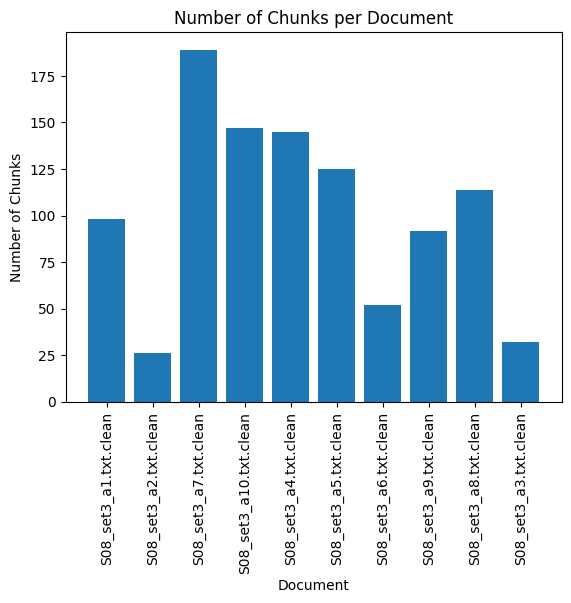

In [66]:
# Get document labels and unique document names
pattern = r'_\d+\.npy$'
labels = np.array([re.sub(pattern,'', os.path.basename(filename)) for filename in npy_files])

# Count how many embeddings files (one file per chunk) are associated with each corpus file
label_counts = Counter(labels)
doc_names = list(label_counts.keys())
counts = list(label_counts.values())

# Plot histogram of chunk counts per file
plt.bar(doc_names, counts)

# Format plot
plt.xlabel('Document')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks per Document')
plt.xticks(rotation=90)

plt.show()

## 2. Embedding Distribution by Document
Another aspect that may affect the system's performance is the distribution of embeddings for the corpus documents. As mentioned above, if the document embeddings form well-defined clusters, the likelihood of including irrelevant context for questions closely related to a specific document's topid would decrease. However, for questions related to multiple different documents, the relevant context may not include sentences from all relevant documents depending on the distance in embeddings space between the question and the document chunks. Ideally for the best performance, the documents embeddings form well-defined clusters and the questions asked related to the topics of the specific documents.

Plotting only the first 2 features of the embedding vectors, color-coded by document, does not provide a great picture of the embedding distributions because 2 features is too few to accurately represent the data. To help overcome this, PCA was performed and the top 2 principal components were plotted to visualize the data projected in the directions of the most variation. This led to the ability to visualize some distinct clusters in the documents, although there was still quite a bit of cluster overlap in this 2D view. Despite this overlap, the higher dimensionality of the embeddings likely allows for more cluster separability across different dimensions, likely leading to pretty well-defined document clusters, meaning a good potential to avoid including irrelevant context data in questions relevant to a specific document.

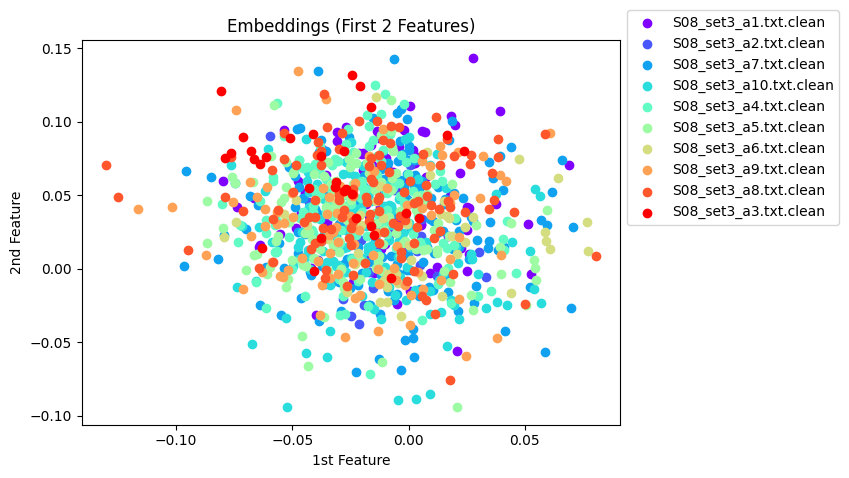

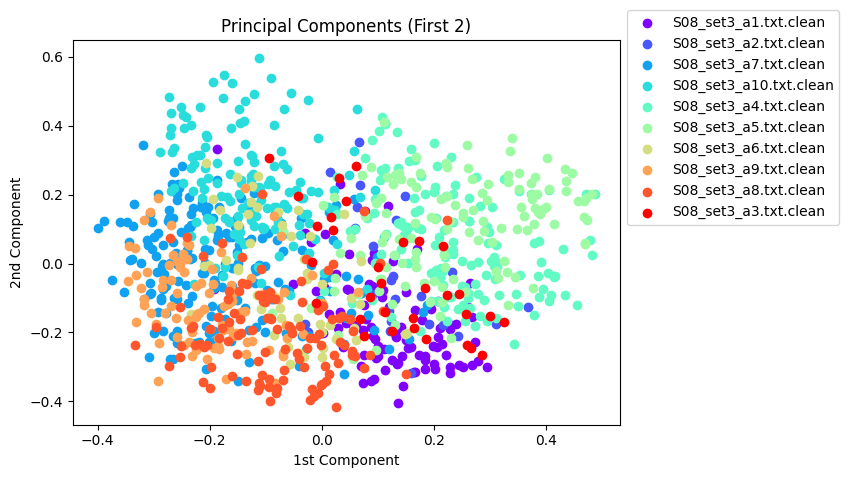

In [7]:
# Initialize colors list
colors = cm.rainbow(np.linspace(0, 1, len(doc_names)))

# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA

# Plot embeddings and PCA data
for j in range(len(doc_names)):
    doc = doc_names[j]
    docMask = labels == doc
    ax1.scatter(embeddings[docMask,0],embeddings[docMask,1],color=colors[j],label=doc)
    ax2.scatter(principal_components[docMask,0],principal_components[docMask,1],color=colors[j],label=doc)


# Format plots
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
line, label = ax1.get_legend_handles_labels()
fig1.legend(line, label,bbox_to_anchor=(1.33, 1))
fig1.tight_layout()

ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
line2, label2 = ax2.get_legend_handles_labels()
fig2.legend(line2, label2,bbox_to_anchor=(1.33, 1))
fig2.tight_layout()

plt.show()

# Additional Analysis
2 additional analyses beyond the requirement of 2 analyses.

## 3. Questions per Document
Another factor that may influence the system's performance is the distribution of questions in our validation set of questions with known answers. The system will likely end up performing the best for questions similar to those in our validation set since we're adjusting the system parameter based on the system's performance when generating answers to these validation questions. If the questions are only relevant to specific documents, then the deployed system would likely perform poorly (or at least less well) when given questions relating to other documents or topics. By plotting a histogram of the number of questions relevant to each document (based on the `ArticleFile` associated with each question), we can see that the questions are only related to 2 documents (ones about Millard Fillmore and Abraham Lincoln). This suggests that the system might generate good answers to questions about these topics, but worse answers for questions about other topics.

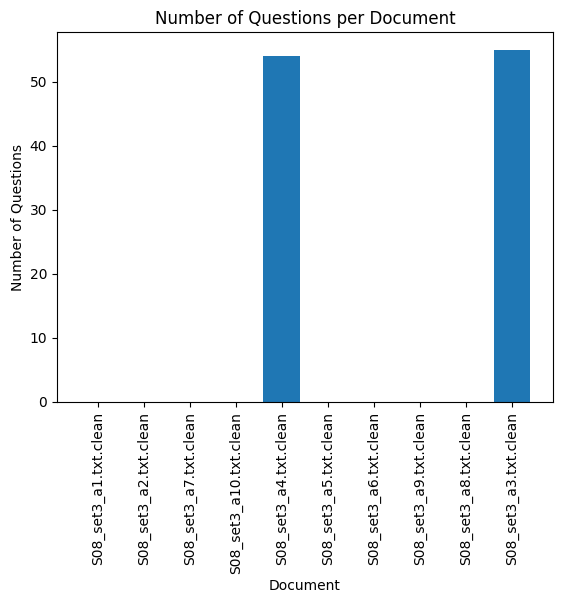

In [61]:
# Read in questions
questions = pd.read_csv("../qa_resources/questions.csv", delimiter="\t")

qCounts = {}
for doc in doc_names:
    articleFile = doc.removesuffix('.txt.clean')
    qCounts[doc] = np.sum(questions['ArticleFile'] == articleFile)

# Plot histogram of question counts for each document
plt.bar(qCounts.keys(), qCounts.values())

# Format plot
plt.xlabel('Document')
plt.ylabel('Number of Questions')
plt.title('Number of Questions per Document')
plt.xticks(rotation=90)

plt.show()

## 4. Embedding Distributions of Questions and Answers
Another aspect that may affect system performance is the distribution of embedding vectors of the questions and answers in the validation set. Since the validation set of questions is used to adjust the system and model parameters based on the performance on this set, the deployed system will likely work best on questions similar to those in the validation set. Ideally, the quesstions embedding vectors would be close to the embedding vectors of the corpus document that the question is about. Additionally, the embedding vectors for the ground truth answers should be close to the corpus document and question embedding vectors as well, since the system will likely generate an answer close to the relevant context in embedding space.

Like in the embeddings distribution analysis above, plotting the first 2 features of the embedding vectors doesn't give us very good insights. However, plotting the question and answer embedding vectors projected onto the principal components of the corpus document embeddings (so the visualization is comparable when plotting questions, answeres, and documents embeddings on the same plot), results in more meaningful insights. In general, the questions embeddings are in the same cluster area as the document embeddings and the answer embeddings. There is some overlap between the clusters; however, this overlap may be less significant when all of the higher dimensions are taken into account during the search process. This is promising because it indicates that the system will be tuned to be good at answering questions relevant to specific document topics. However, this performance may still be limited to questions about the topics in the two documents used to create the questions. Additionally, the model may not perform well if the the question is relevant to multiple documents.

First, we need to calculate the embeddings for all of the questions and answers and project the embeddings onto the principal components.

In [63]:
qEmbeddings = None
aEmbeddings = None

# Get embeddings for all questions and answers
for idx, row in questions.iterrows():
    qText = row['Question']
    aText = '' if pd.isnull(row['Answer']) else row['Answer']
    qEmbedding = pipeline.get_embedding(qText)
    qEmbeddings = qEmbedding.T if qEmbeddings is None else np.vstack([qEmbeddings, qEmbedding.T])
    aEmbedding = pipeline.get_embedding(aText)
    aEmbeddings = aEmbedding.T if aEmbeddings is None else np.vstack([aEmbeddings, aEmbedding.T])

# Project question & answer embeddings along document principal components for plotting
qPCA = pca_obj.transform(qEmbeddings)
aPCA = pca_obj.transform(aEmbeddings)

Next, plot the embeddings for the documents, questions, and answers, color-coded by corpus document. The dots indicate corpus document embeddings, the triangles indicate questions, and the squares indicate answers.

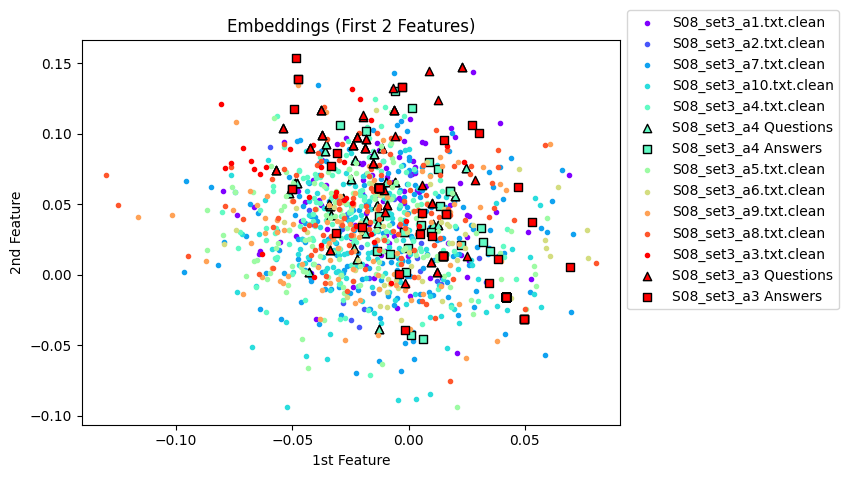

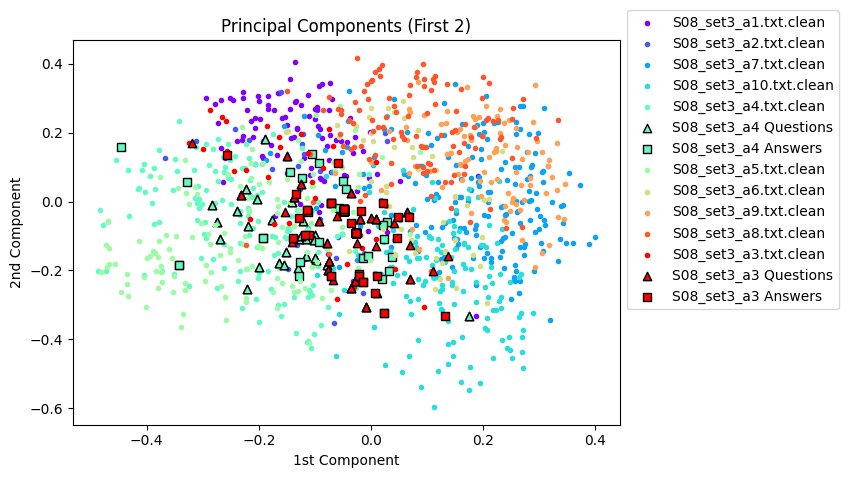

In [65]:
# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA

# Plot embeddings and PCA data
for j in range(len(doc_names)):
    doc = doc_names[j]
    docMask = labels == doc
    # Plot document embeddings & PCA
    ax1.scatter(embeddings[docMask,0],embeddings[docMask,1],marker='.',color=colors[j],label=doc)
    ax2.scatter(principal_components[docMask,0],principal_components[docMask,1],marker='.',color=colors[j],label=doc)

    articleFile = doc.removesuffix('.txt.clean')
    questionMask = questions['ArticleFile'] == articleFile
    if np.sum(questionMask) > 0:
        # Plot question & answer PCA
        ax2.scatter(qPCA[questionMask,0],qPCA[questionMask,1],color=colors[j],marker='^',edgecolor='black',linewidth=1,label=f'{articleFile} Questions')
        ax2.scatter(aPCA[questionMask,0],aPCA[questionMask,1],color=colors[j],marker='s',edgecolor='black',linewidth=1,label=f'{articleFile} Answers')
        # Plot question & answer embeddings
        ax1.scatter(qEmbeddings[questionMask,0],qEmbeddings[questionMask,1],color=colors[j],marker='^',edgecolor='black',linewidth=1,label=f'{articleFile} Questions')
        ax1.scatter(aEmbeddings[questionMask,0],aEmbeddings[questionMask,1],color=colors[j],marker='s',edgecolor='black',linewidth=1,label=f'{articleFile} Answers')

# Format plots
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
line, label = ax1.get_legend_handles_labels()
fig1.legend(line, label,bbox_to_anchor=(1.33, 1))
fig1.tight_layout()

ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
line2, label2 = ax2.get_legend_handles_labels()
fig2.legend(line2, label2,bbox_to_anchor=(1.33, 1))
fig2.tight_layout()

plt.show()
